<h1  style="color:tomato;"><center> Hot Trends in Machine Learning  - Topic modelling </center></h1>

# Summary

<p style="font-size:15px;"> This project aims to discover the trends in machine learning through application of unsupervised learning (LDA) on a dataset of NIPS research papers. Below is a sample visualization using pyLDAvis. An interactive plot of the same is provided further below. 
    </p>


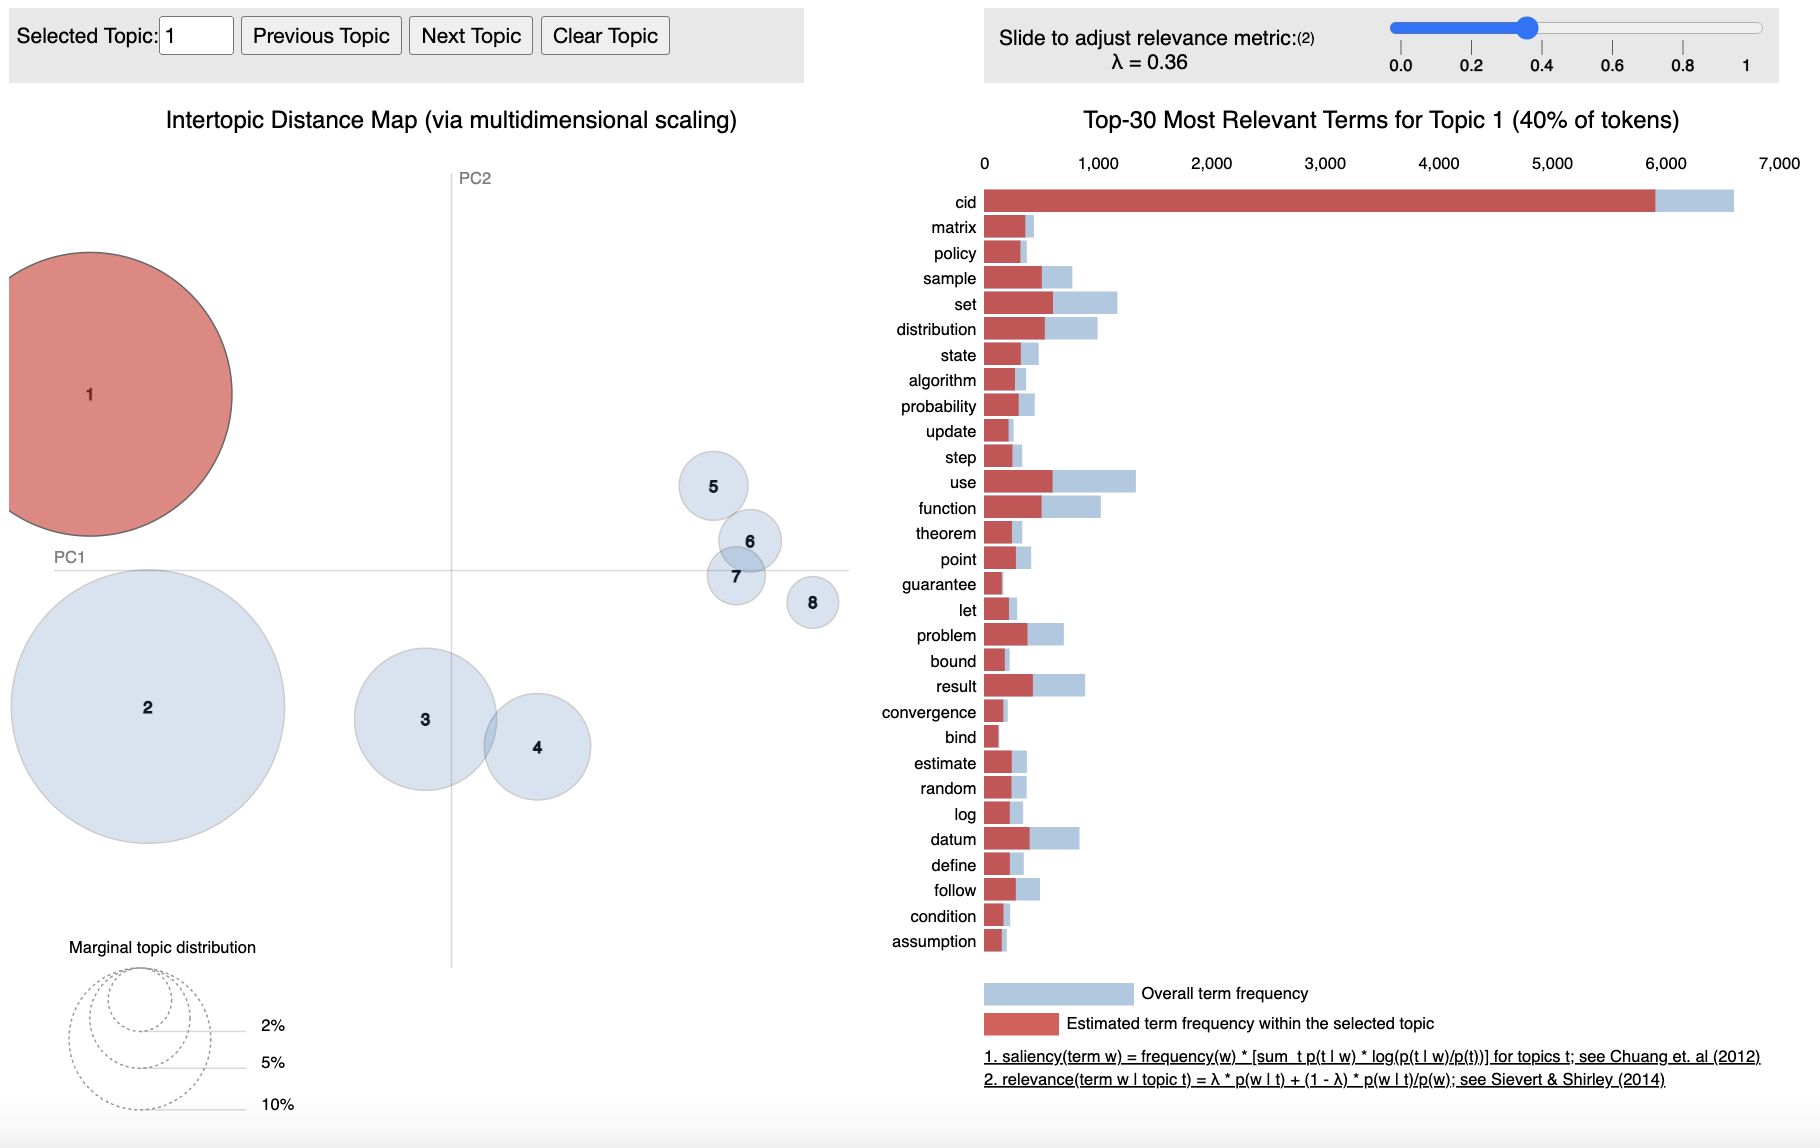

# Background

In statistics and natural language processing, a topic model is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents. Topic modeling is a frequently used text-mining tool for discovery of hidden semantic structures in a text body.

Latent Dirichlet allocation (LDA), perhaps the most common topic model currently in use, is a generalization of PLSA. Developed by David Blei, Andrew Ng, and Michael I. Jordan in 2002, LDA introduces sparse Dirichlet prior distributions over document-topic and topic-word distributions, encoding the intuition that documents cover a small number of topics and that topics often use a small number of words [wikipedia].

# Prerequisites

The below code expects the dataset (of NIPS research Papers) to be downloaded and available locally. Fret not! You can downoad the same using https://github.com/Harikr16/NIPS_Downloader repository (NB: It might take some time depending on your machine).

# Let's begin !!

## Importing required libraries

In [121]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os

# Load the regular expression library
import re

#NLP packages
import gensim
from gensim.utils import simple_preprocess
# NLTK Stop words
import nltk;
nltk.download('stopwords');
from nltk.corpus import stopwords
import gensim.corpora as corpora

from pprint import pprint;

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hraghu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Read  dataset 

In [179]:
# Path where the dataset is saved
dataset_path = "papers.csv"

# Segment of the research paper to be used for analysis (e.g. Title, Abstract, Paper Text etc.)
main_feature = "title"
processed_feature = main_feature + '_processed'

# Path where the hyperparameter tuning should be saved
save_file_name = 'lda_tuning_results_2_'+main_feature+'.csv'

In [158]:
# Read the CSV file into a pandas DataFrame
papers = pd.read_csv(dataset_path)

# Print head
papers.head()

,id,authors,year,title,pdf_name,abstract,paper_text
0,0004d0b59e19461ff126e3a08a814c33,"['Martijn Leisink', 'Bert Kappen']",2001,"Means, Correlations and Bounds",0004d0b59e19461ff126e3a08a814c33,The partition function for a Boltzmann ma...,Means. Correlations and Bounds \n\nM.A.R. ...
1,0004d0b59e19461ff126e3a08a814c33,['Seongmin Ok'],2020,A graph similarity for deep learning,0004d0b59e19461ff126e3a08a814c33,Graph neural networks (GNNs) have been success...,A Graph Similarity for Deep Learning\n\nSeongm...
2,000c076c390a4c357313fca29e390ece,"['Christoph Dann', 'Teodor Vanislavov Marinov'...",2021,Beyond Value-Function Gaps: Improved Instance-...,000c076c390a4c357313fca29e390ece,We provide improved gap-dependent regret bound...,Beyond Value-Function Gaps: Improved\nInstance...
3,003dd617c12d444ff9c80f717c3fa982,"['Ahmed Touati', 'Yann Ollivier']",2021,Learning One Representation to Optimize All Re...,003dd617c12d444ff9c80f717c3fa982,We introduce the forward-backward (FB) represe...,Learning One Representation to Optimize All\nR...
4,00411460f7c92d2124a67ea0f4cb5f85,"['Maxim Raginsky', 'Svetlana Lazebnik', 'Rebec...",2008,Near-minimax recursive density estimation on t...,00411460f7c92d2124a67ea0f4cb5f85,NaN,Near-Minimax Recursive Density Estimation\non ...


### Trim dataset

In [159]:
# Remove unnecessary columns
papers = papers.drop(columns=['id', 'pdf_name'], axis=1)

# sample only 100 papers - apply of Paper text is being used
papers = papers.sample(100)

# Print out the first rows of papers
papers.head()

,authors,year,title,abstract,paper_text
2074,"['Awais Muhammad', 'Fengwei Zhou', 'Chuanlong ...",2021,MixACM: Mixup-Based Robustness Transfer via Di...,Deep neural networks are susceptible to advers...,MixACM: Mixup-Based Robustness Transfer via\nD...
11154,"['Sebastian Zeng', 'Florian Graf', 'Christoph ...",2021,Topological Attention for Time Series Forecasting,The problem of (point) forecasting univariate ...,Topological Attention for Time Series Forecast...
9449,"['Frank Schneider', 'Felix Dangel', 'Philipp H...",2021,Cockpit: A Practical Debugging Tool for the Tr...,"When engineers train deep learning models, the...",COCKPIT: A Practical Debugging Tool\nfor the T...
12788,"['Siddhant Jayakumar', 'Razvan Pascanu', 'Jack...",2020,Top-KAST: Top-K Always Sparse Training,Sparse neural networks are becoming increasing...,Top-KAST: Top-K Always Sparse Training\n\nSidd...
13186,"['Juan Perdomo', 'Jack Umenberger', 'Max Simch...",2021,Stabilizing Dynamical Systems via Policy Gradi...,Stabilizing an unknown control system is one o...,Stabilizing Dynamical Systems via Policy Gradi...


## Preprocessing the dataset 

In [163]:
# Remove punctuation
papers[processed_feature] = papers[main_feature].map(lambda x: re.sub('[,\.!?:]', '', x))

# Convert the titles to lowercase
papers[processed_feature] = papers[processed_feature].map(lambda x: x.lower())

# Print out the first rows of papers
papers[processed_feature].head()

2074     mixacm mixup-based robustness transfer via dis...
11154    topological attention for time series forecasting
9449     cockpit a practical debugging tool for the tra...
12788                top-kast top-k always sparse training
13186    stabilizing dynamical systems via policy gradi...
Name: title_processed, dtype: object

In [165]:
# Convert sentece to words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = papers[processed_feature].values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['mixacm', 'mixup', 'based', 'robustness', 'transfer', 'via', 'distillation', 'of', 'activated', 'channel', 'maps']


In [166]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [167]:
# Define stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'cid'])

# Helper functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [168]:
# IMP : Uncomment the below code if you are running for the first time
# !python3.9 -m spacy download en_core_web_sm;

# Import spacy package
import spacy;

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1][0][:30])

['base', 'robustness', 'transfer', 'distillation', 'activate', 'channel', 'map']


In [169]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]


## Build a simple LDA model

In [171]:
# Build LDA model with default hyperparameters
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.039*"neural" + 0.029*"learn" + 0.020*"deep" + 0.020*"network" + '
  '0.020*"differential" + 0.020*"partial" + 0.020*"equation" + 0.020*"net" + '
  '0.010*"training" + 0.010*"communicating"'),
 (1,
  '0.041*"semi" + 0.029*"learn" + 0.029*"learning" + 0.027*"tree" + '
  '0.015*"robust" + 0.015*"base" + 0.015*"online" + 0.015*"human" + '
  '0.015*"sample" + 0.015*"label"'),
 (2,
  '0.021*"learning" + 0.021*"visual" + 0.021*"net" + 0.021*"top" + '
  '0.011*"regularization" + 0.011*"forecast" + 0.011*"function" + '
  '0.011*"training" + 0.011*"sparse" + 0.011*"predict"'),
 (3,
  '0.026*"network" + 0.017*"object" + 0.017*"process" + 0.017*"feature" + '
  '0.017*"gaussian" + 0.017*"region" + 0.017*"learn" + 0.009*"estimation" + '
  '0.009*"detection" + 0.009*"constrain"'),
 (4,
  '0.022*"network" + 0.022*"datum" + 0.022*"optimal" + 0.022*"loss" + '
  '0.022*"learn" + 0.011*"deep" + 0.011*"descent" + 0.011*"map" + 0.011*"high" '
  '+ 0.011*"private"'),
 (5,
  '0.044*"learn" + 0.022*"

## Evaluate the coherence score of built model

In [172]:
# Import CoherenceModel from gensim library
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.4600860978983562


## Hyperparameter tuning

In [173]:
# Import required packages

import numpy as np

import tqdm

In [174]:
# supporting function to calculate coherence value
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b, 
                                           workers = 8)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v', processes = 8)
    
    return coherence_model_lda.get_coherence()

In [180]:
# Grid search values
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)), position=0, leave=True)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv(save_file_name, index=False)
    pbar.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 540/540 [28:46<00:00,  3.20s/it]


## Visualize the impact of hyperparameters

In [144]:
# Import required packages
import seaborn as sns
import matplotlib.pyplot as plt

In [151]:
# Read the results of hyperparameter optimization
df = pd.read_csv('lda_tuning_results.csv')
df.head()

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.255210
1,75% Corpus,2,0.01,0.31,0.257202
2,75% Corpus,2,0.01,0.61,0.251002
3,75% Corpus,2,0.01,0.9099999999999999,0.250497
4,75% Corpus,2,0.01,symmetric,0.251002


In [152]:
# Identify the hyperparameter with highest ciherence value
df[df['Coherence'] == max(df['Coherence'] )]

,Validation_Set,Topics,Alpha,Beta,Coherence
268,75% Corpus,10,asymmetric,0.9099999999999999,0.425221


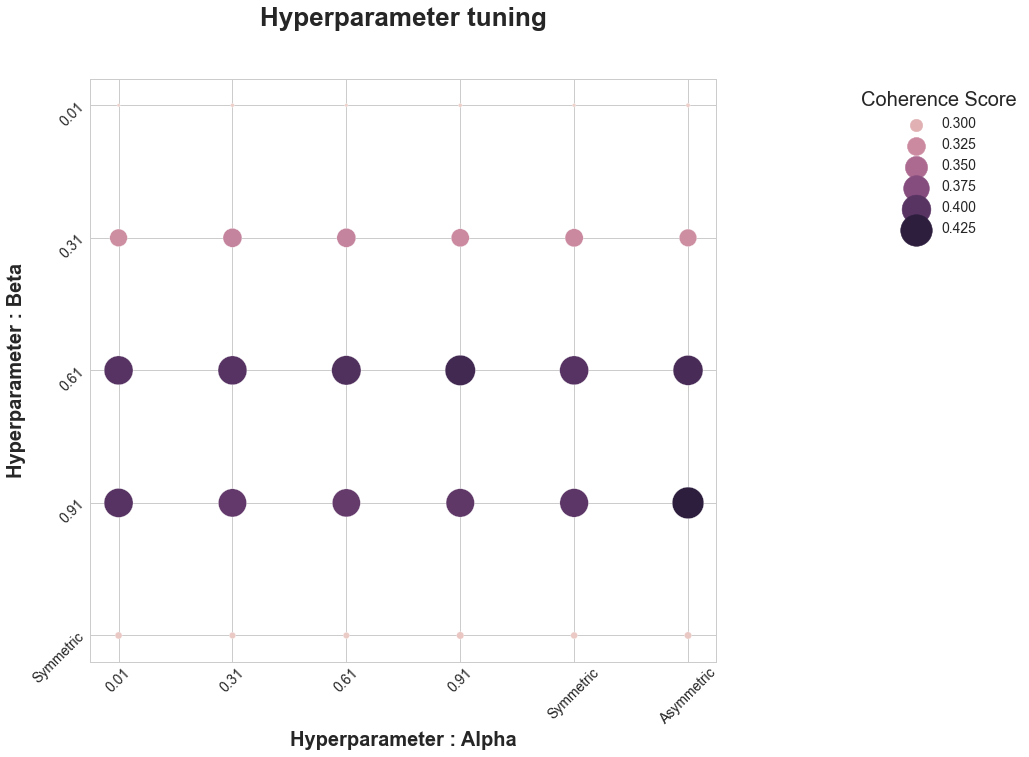

In [153]:
# Subset the dataset with No of topics = 10
topic_10 = df[(df['Topics']==10 )& (df['Validation_Set']=='75% Corpus')]

# Plot the results as scatter plot
plt.style.use('seaborn-whitegrid')

# Create figure
fig = plt.figure(figsize = (10, 10))
ax = plt.subplot(111)

# Build a scatter plot
sns.scatterplot(data = topic_10, x= 'Alpha', y = 'Beta', size = 'Coherence', hue = 'Coherence', sizes = (10, 1000), ax = ax)

# Clean X and Y labels, ticks and legends
locs, labels = plt.xticks()
plt.xticks(locs, ['0.01', '0.31', '0.61', '0.91', 'Symmetric', 'Asymmetric'], rotation = 45)

locs, labels = plt.yticks()
plt.yticks(locs, ['0.01', '0.31', '0.61', '0.91', 'Symmetric'], rotation = 45)

plt.legend(bbox_to_anchor=(1.5, 1), title = 'Coherence Score', title_fontsize = 20)

plt.xlabel('Hyperparameter : Alpha', fontweight = 'bold', fontsize = 20)
plt.ylabel('Hyperparameter : Beta', fontweight = 'bold', fontsize = 20)

plt.title('Hyperparameter tuning', fontweight = 'bold', y=1.08, fontsize = 26)

plt.show()



## Build Final model

In [154]:
num_topics = 10

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha='asymmetric',
                                           eta=0.9)

## Visualize the final model

In [156]:
# IMP : Uncomment and run the below snippet if running for the first time
# !pip install pyLDAvis

# Import required packages
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import os

import warnings
warnings.filterwarnings('ignore')

# Visualize the topics
pyLDAvis.enable_notebook()


LDAvis_data_filepath = os.path.join('ldavis_tuned_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, 'ldavis_tuned_'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.143796  0.029694       1        1  43.285830
5     -0.112417 -0.013962       2        1  23.653730
8     -0.055542 -0.058152       3        1  12.100279
9     -0.017980  0.045075       4        1   6.225334
7      0.010622 -0.032592       5        1   4.500958
2      0.011650  0.016654       6        1   4.078768
1      0.023903  0.018119       7        1   3.218173
4      0.058553 -0.010084       8        1   2.193325
0      0.112501 -0.000754       9        1   0.466406
3      0.112506  0.006001      10        1   0.277198, topic_info=           Term         Freq        Total Category  logprob  loglift
139     network  1278.000000  1278.000000  Default  30.0000  30.0000
130       model  2068.000000  2068.000000  Default  29.0000  29.0000
1074   training   764.000000   764.000000  Default  28.0000  28.0000
1310      image   830.000000   830.000000  Default  27.0000  27.0000
212        task   724.000000   724.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
176      relate     0.255558   103.795232  Topic10  -7.7558  -0.1185
149   operation     0.224673    73.318690  Topic10  -7.8846   0.1003
130       model     0.274102  2068.824252  Topic10  -7.6858  -3.0408
229         use     0.257069  1443.349956  Topic10  -7.7499  -2.7449
163     problem     0.242563   713.760772  Topic10  -7.8080  -2.0988

[663 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
1167       1  0.043370    acceleration
1167       2  0.130111    acceleration
1167       3  0.043370    acceleration
1167       4  0.043370    acceleration
1167       5  0.693924    acceleration
...      ...       ...             ...
11181      3  0.039444  ﬂow_prediction
2195       1  0.156464      ﬂow_stream
2195       2  0.156464      ﬂow_stream
2195       3  0.156464      ﬂow_stream
2195       8  0.312928      ﬂow_stream

[2652 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 9, 10, 8, 3, 2, 5, 1, 4])